# AXO_Histos for Efficiency

In [16]:
from dask.distributed import Client

client = Client("tls://192.168.121.180:8786")
client

<Client: 'tls://192.168.121.180:8786' processes=2 threads=2, memory=5.72 GiB>

In [17]:
import uproot as ur
import hist
import time
import json
import dask
import dill 
import operator
import numba
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.preprocessing import normalize
from pprint import pprint
from itertools import combinations, combinations_with_replacement
from collections import defaultdict

import awkward as ak
import dask_awkward as dak
import hist.dask as hda
import vector
vector.register_awkward()

from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import coffea.processor as processor
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

from ScoutingNanoAODSchema import ScoutingNanoAODSchema
client.upload_file("./ScoutingNanoAODSchema.py");
NanoAODSchema.warn_missing_crossrefs = False

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.dpi'] = 50
hep.style.use('CMS')

## Coffea Histogram Processor
Here, we add in the information to makeAXOhists to create the efficiency curves. I have deleted much of the graphing information (invariant mass plots, etc.) to make the code a little less messy. 

In [61]:
thresholds = {
        'vtight'  : {'name'  : 'AXO VTight', 'score' : 25000/16},
        'tight'   : {'name'  : 'AXO Tight', 'score' : 20486/16},
        'nominal' : {'name'  : 'AXO Nominal', 'score' : 18580/16},
        'loose'   : {'name'  : 'AXO Loose', 'score' : 17596/16},
        'vloose'  : {'name'  : 'AXO VLoose', 'score' : 15717/16},
}

def multipage(filename, figs=None, dpi=200):
    """Creates a pdf with one page per plot"""
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
        print("No figures handed")
    for fig in figs:
        plt.figure(fig).savefig(pp, format='pdf')
    pp.close()

def getHist(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)

def draw_thresholds(ax, threshold_map):
    for th in threshold_map.values():
        ax.axvline(x=th['score'], 
                   label=th['name'], 
                   color=ax._get_lines.get_next_color(),
                   linestyle='--',
                   linewidth=3,
        )

def draw_hist1d(hist_in, ax, label='', rebin=1, norm=False):
    counts, _, bins = hist_in[:,hist.rebin(rebin)].to_numpy()
    if len(counts)>0: # check that there are events to plot
        _counts = counts[0]/(np.sum(counts[0])*np.diff(bins)) if norm else counts[0]
        errs = np.sqrt(counts[0])/(np.sum(counts[0])*np.diff(bins)) if norm else np.sqrt(counts[0])
        
        _errs = np.where(_counts==0, 0, errs)
        bin_centres = 0.5*(bins[1:] + bins[:-1])
        l = ax.errorbar(x=bin_centres,y=_counts,yerr=_errs,linestyle='')
        color = l[0].get_color()
        ax.errorbar(x=bins[:-1],y=_counts,drawstyle='steps-post',label=label,color=color)
        
    else:        
        l = ax.errorbar(x=[],y=[],yerr=[],drawstyle='steps-post') # plot nothing
        color = l[0].get_color()
        ax.errorbar(x=[],y=[],drawstyle='steps-post',label=label,color=color)
        
def draw_efficiency(ortho_hist, trig_hist, ax, label='', rebin=5, norm=False):
    ortho_counts, _, ortho_bins = ortho_hist[:,hist.rebin(rebin)].to_numpy()
    trig_counts, _, trig_bins = trig_hist[:,hist.rebin(rebin)].to_numpy()
    
    # Calculating efficiency
    eff = (trig_counts[0] / ortho_counts[0]) * 100
    x = 0.5*(trig_bins[0:-1] + trig_bins[1:])
    
    # Error bars
    f = trig_counts[0] / ortho_counts
    sig_trig = np.sqrt(np.sum(trig_counts[0]))
    sig_ortho = np.sqrt(np.sum(ortho_counts[0]))
    error = f*np.sqrt((sig_trig/trig_counts[0])**2 + (sig_ortho/ortho_counts[0])**2)
    
    # Plotting it
    l = ax.errorbar(x=x, y=eff, yerr=error, linestyle='')
    color = l[0].get_color()
    ax.errorbar(x=x, y=eff, label=label, color=color)
    # ax.errorbar(x=x, y=eff, yerr=error, color=color)
    # ax.plot(x=x, y=eff, marker=".", label=label, color=color)
           
# Deleted draw_hist2d and find_diObjs

class MakeAXOHists (processor.ProcessorABC):
    def __init__(self, trigger_paths=[], has_scores=True, is_scouting=False, 
                 extra_cut='', thresholds=None, object_dict=None,
                 efficiency_triggers={}):
        if is_scouting:
             the_object_dict =  {
                            #   'ScoutingJet' :      {'cut' : [('pt', 30.)], 'label' : 'j'},
                                # Scouting_test doesn't have ScoutingJet
                                'ScoutingPFJet' : {'cut' :[('pt', 20.)], 'label' : 'j'}, 
                                'ScoutingElectron' : {'cut' : [('pt', 10)], 'label' : 'e'},
                                'ScoutingMuonNoVtx' :     {'cut' : [('pt', 3)], 'label' : '\mu'},
                                'ScoutingPhoton' :     {'cut' : [('pt', 10)], 'label' : '\gamma'},
                                'L1Jet' :    {'cut' : [('pt', 0.1)], 'label' : 'L1j'},
                                'L1EG' :     {'cut' : [('pt', 0.1)], 'label' : 'L1e'},
                                'L1Mu' :     {'cut' : [('pt', 0.1)], 'label' : 'L1\mu'}
                               }
        
        else:
            the_object_dict =  {'Jet' :      {'cut' : [('pt', 30.)], 'label' : 'j'},
                                'Electron' : {'cut' : [('pt', 10)], 'label' : 'e'},
                                'Muon' :     {'cut' : [('pt', 3)], 'label' : '\mu'},
                                'L1Jet' :    {'cut' : [('pt', 0.1)], 'label' : 'L1j'},
                                'L1EG' :     {'cut' : [('pt', 0.1)], 'label' : 'L1e'},
                                'L1Mu' :     {'cut' : [('pt', 0.1)], 'label' : 'L1\mu'}
                               }      
        self.run_dict = {
            'thresholds' : thresholds if thresholds is not None else {
                'AXOVTight_EMU'  : {'name'  : 'AXO VTight', 'score' : 25000/16},
                'AXOTight_EMU'   : {'name'  : 'AXO Tight', 'score' : 20486/16},
                'AXONominal_EMU' : {'name'  : 'AXO Nominal', 'score' : 18580/16},
                'AXOLoose_EMU'   : {'name'  : 'AXO Loose', 'score' : 17596/16},
                'AXOVLoose_EMU'  : {'name'  : 'AXO VLoose', 'score' : 15717/16},
            },
            'objects' : object_dict if object_dict is not None else the_object_dict
        }

        self.sorted_keys = sorted(self.run_dict['thresholds'],key=lambda i: self.run_dict['thresholds'][i]['score'])
        self.trigger_paths = trigger_paths
        self.has_scores = has_scores
        self.is_scouting = is_scouting
        self.extra_cut = extra_cut
        
        self.dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        self.score_axis = hist.axis.Regular(100, 0, 4000, name="score", label='Anomaly Score')
        self.mult_axis = hist.axis.Regular(200,0,201, name="mult", label=r'$N_{obj}$')
        #self.pt_axis = hist.axis.Regular(500,0,5000, name="pt", label=r"$p_{T}$ [GeV]")
        self.pt_axis = hist.axis.Regular(500,0,2000, name="pt", label=r"$p_{T}$ [GeV]")
        self.eta_axis = hist.axis.Regular(150,-5,5, name="eta", label=r"$\eta$")
        self.phi_axis = hist.axis.Regular(30,-4,4, name="phi", label=r"$\phi$")
        self.met_axis = hist.axis.Regular(250,0,2500, name="met", label=r"$p^{miss}_{T} [GeV]$")
        self.ht_axis = hist.axis.Regular(100,0,2000, name="ht", label=r"$H_{T}$ [GeV]")
        self.minv_axis = hist.axis.Regular(3000,0,3000, name="minv", label=r"$m_{obj_{1},obj_{2}}$ [GeV]")
                
        # Efficiency initialization
        self.efficiency_triggers = efficiency_triggers
        

    def process(self, events):
        dataset = events.metadata['dataset']
        cutflow = defaultdict(int)
        cutflow['start'] = ak.num(events.event, axis=0)
        hist_dict = {}
               
        # Saturated-Jets event cut
        events = events[dak.all(events.L1Jet.pt<1000,axis=1)]
        # Saturated-MET event cut
        events = events[dak.flatten(events.L1EtSum.pt[(events.L1EtSum.etSumType==2) & (events.L1EtSum.bx==0)])<1040]      
        
        # Efficiency stuff
        if self.efficiency_triggers:
            efficiency_histograms = {}
            for k in self.efficiency_triggers:
                ortho_trig = self.efficiency_triggers[k][0] # First trigger is orthogonal dataset
                int_trigs = self.efficiency_triggers[k][1:] # All others are triggers of interest

                ortho_trig_br = getattr(events,ortho_trig.split('_')[0])
                ortho_trig_path = '_'.join(ortho_trig.split('_')[1:])
                events_ortho = events[getattr(ortho_trig_br,ortho_trig_path)]
                
                for int_trig in int_trigs:
                    
                    int_trig_br = getattr(events, int_trig.split('_')[0])
                    int_trig_path = '_'.join(int_trig.split('_')[1:])
                    events_int = events[getattr(int_trig_br,int_trig_path) & getattr(ortho_trig_br,ortho_trig_path)]
                        
                    for obj,obj_dict in self.run_dict['objects'].items():
                        cut_list = obj_dict['cut']
                        label = obj_dict['label']
                        isL1Obj = 'L1' in obj
                        isScoutingObj = 'Scouting' in obj
                        ortho_br = getattr(events_ortho, obj)
                        int_br = getattr(events_int, obj)

                        # Filter only L1 Objects from BX==0
                        if isL1Obj:
                            ortho_br = getattr(events_ortho, obj)
                            int_br = getattr(events_int, obj)

                        # Apply list of cuts to relevant branches
        #                 for var, cut in cut_list:
        #                     ortho_mask = (getattr(ortho_br,var) > cut)
        #                     ortho_br = ortho_br[ortho_mask]

        #                     int_mask = (getattr(int_br,var) > cut)
        #                     int_br = int_br[int_mask]

        #                     comp_mask = (getattr(comp_br,var) > cut)
        #                     comp_br = comp_br[comp_mask]

                        h_ortho = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
                        h_ortho.fill(dataset=dataset, pt=dak.flatten(ortho_br.pt)) # Takes only pT values from passing?
                        hist_dict[f'ortho_{obj}_{ortho_trig}'] = h_ortho 
                        
                        h_int = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
                        h_int.fill(dataset=dataset, pt=dak.flatten(int_br.pt)) # Takes only pT values from passing?
                        hist_dict[f'int_{obj}_{int_trig}'] = h_int

        # Trigger requirement
        for trigger_path in self.trigger_paths: # loop over trigger paths
            events_trig = None
                
            if trigger_path == "all":
                events_trig = events
                                
            else:
                trig_br = getattr(events,trigger_path.split('_')[0])
                trig_path = '_'.join(trigger_path.split('_')[1:])
                events_trig = events[getattr(trig_br,trig_path)] # select events passing this trigger

                                
            cutflow[trigger_path] = ak.num(events_trig.event, axis=0)

# Removed scalar branches and associated plots (ht, met, total pt, etc.)
# Removed anomaly score information
# Removed diObj information

            # Process object collections - w/trigger
            for obj,obj_dict in self.run_dict['objects'].items():
                cut_list = obj_dict['cut']
                label = obj_dict['label']
                isL1Obj = 'L1' in obj
                isScoutingObj = 'Scouting' in obj
                br = getattr(events_trig, obj)
                
                # Filter only L1 Objects from BX==0
                if isL1Obj:
                    br = br[br.bx==0]

                # Apply list of cuts to relevant branches
                for var, cut in cut_list:
                    mask = (getattr(br,var) > cut)
                    br = br[mask]
                
                # Fill 1D histograms - w/trigger

                h_pt = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
                h_pt.fill(dataset=dataset, pt=dak.flatten(br.pt))
                hist_dict[f'pt_{obj}_{trigger_path}'] = h_pt
                
                h_pt_0 = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
                h_pt_0.fill(dataset=dataset, pt=dak.flatten(br.pt[:,0:1]))
                hist_dict[f'pt0_{obj}_{trigger_path}'] = h_pt_0
                
                h_pt_1 = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
                h_pt_1.fill(dataset=dataset, pt=dak.flatten(br.pt[:,1:2]))
                hist_dict[f'pt1_{obj}_{trigger_path}'] = h_pt_1


# Removed all info except for pt (minv, eta, phi, etc.)
# Removed 2D histograms info
# Removed OS muon and minv information         

        return {
            'cutflow' : cutflow,
            'hists'   : hist_dict,
            'trigger' : self.trigger_paths if len(self.trigger_paths)>0 else None
        }

    def postprocess(self, accumulator):
        return accumulator

# Removed pure events information

## Configure & Process Datasets

### Preprocess Input Files

In [57]:
url = "https://raw.githubusercontent.com/cms-l1-dpg/L1MenuRun3/master/official/L1Menu_Collisions2024_v1_1_0/PrescaleTable/L1Menu_Collisions2024_v1_1_0.csv"
df = pd.read_csv(url)
active_cols = [x for x in df.columns.to_list() if x not in ['Index','Name','Emergency']]
all_L1_seeds = df['Name'].to_numpy()
active_l1_seeds = df[(df[active_cols]>0).any(axis=1)]['Name'].to_numpy()
fulllumi_L1_seeds = df[df['2p0E34']>0]['Name'].to_numpy()

dataset_test = {
    'Scouting_Golden_test' : {
        'files' : {
            "root://xcache//store/user/pinkaew/scouting_nano_prod_golden/ScoutingPFRun3/crab_ScoutingPFRun3_Run2024D-v1_380385-380470_Golden/240517_205837/0000/scouting_nano_1.root" : "Events"
            # "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_6.root" : "Events",
            # "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_7.root" : "Events",
            # "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_8.root" : "Events",
            # "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_9.root" : "Events"   
            #"root://xcache//store/user/pinkaew/scouting_nano_dev0p3_golden/ScoutingPFMonitor/crab_ScoutingPFMonitor_Run2024E-PromptReco-v1_380963-381380_Golden//240715_232037/0000/scouting_nano_1.root" : "Events"
        }
    }
}


dataset_test_runnable, dataset_test_updated = preprocess(
    dataset_test,
    align_clusters=False,
    step_size=10_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)


with open('2024D_data_filelist-scouting_test.json') as json_file:
    dataset = json.load(json_file)

#dataset_skimmed = {k:v for k,v in dataset.items() if k in ['Scouting_Golden_test']}
dataset_skimmed = {k:v for k,v in dataset.items() if k in ['Scouting_test']}

dataset_runnable, dataset_updated = preprocess(
    dataset_skimmed,
    align_clusters=False,
    step_size=100_000, #default
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

### Run Histogram Producer
Delete majority, if not all, trigger paths

In [64]:
#histpath = ['Scouting_Golden_test','hists']
histpath = ['Scouting_test','hists']

has_scores = True if 'wScores' in histpath[0] else False
is_scouting = True if 'Scouting' in histpath[0] else False
if is_scouting:
    reco_objects = ["ScoutingJet","ScoutingElectron","ScoutingMuonNoVtx","ScoutingPhoton"]
else:
    reco_objects = ["Jet","Electron","Muon"]

triggers = ['DST_PFScouting_JetHT','DST_PFScouting_DoubleMuon','DST_PFScouting_AXONominal','DST_PFScouting_AXOTight','HLT_L1AXOVTight']
trigger_names = { 'all':"All Events",
                      'DST_PFScouting_JetHT':"JetHT",
                      'DST_PFScouting_DoubleMuon':"Double Muon",
                      'DST_PFScouting_AXONominal':"AXO Nominal",
                      'DST_PFScouting_AXOTight':"AXO Tight",
                      'HLT_L1AXOVTight':"AXO Very Tight"}
efficiency_paths = ["DST_PFScouting_JetHT", "DST_PFScouting_AXONominal", "L1_DoubleMu3er2p0_SQ_OS_dR_Max1p6", "DST_PFScouting_DoubleMuon", "DST_PFScouting_AXONominal","L1_SingleJet200"] 
efficiency_triggers = { "Muon Efficiency" : ["DST_PFScouting_JetHT", 
                                      "DST_PFScouting_AXONominal", 
                                      "L1_DoubleMu_15_7"],
                        "Jet Efficiency" : ["DST_PFScouting_DoubleMuon",
                                   # "DST_PFScouting_AXONominal",
                                    "L1_SingleJet200"]}

In [65]:
tstart = time.time()
to_compute = apply_to_fileset(
                MakeAXOHists(trigger_paths=triggers, 
                             has_scores=has_scores, 
                             is_scouting=is_scouting,
                             efficiency_triggers=efficiency_triggers),
                max_chunks(dataset_runnable, 300000),
                #max_chunks(dataset_runnable, 1), #quick testing
                schemaclass=ScoutingNanoAODSchema,
                uproot_options={"allow_read_errors_with_report": (OSError, TypeError, KeyError)}
            )
(hist_result,) = dask.compute(to_compute)
print(f'{time.time()-tstart:.1f}s to process')
hist_result = hist_result[0]

6.1s to process


## Plotting

### pT Distributions 
To confirm that I didn't delete anything too important!

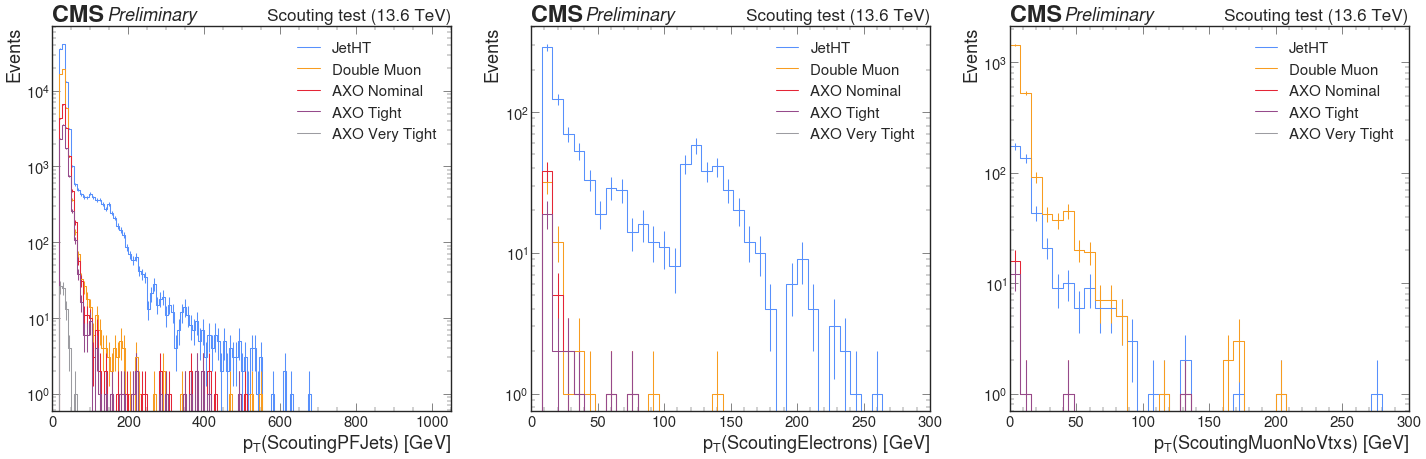

In [54]:
norm = False
#l1_objects = ['L1Jet', 'L1EG','L1Mu']
scouting_objects = ['ScoutingPFJet', 'ScoutingElectron', 'ScoutingMuonNoVtx']

# Pt
get_name = lambda s, suf=None: f'pt_{obj}_{suf}' if suf else f'pt_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,1050), (0,300), (0,300)]
#for i, obj in enumerate(l1_objects):
for i, obj in enumerate(scouting_objects):
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger_names[trigger], rebin=2, norm=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$p_{{T}}({obj+"s"})$ [GeV]', loc='right')
    ax[i].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_yscale('log')
    ymin, ymax = ax[i].get_ylim()
    ax[i].set_ylim((ymin,ymax*1))
    ax[i].legend(loc='upper right')

### Efficiency Curves

**Start with jet efficiency using DoubleMuon**

/tmp/ipykernel_204/2107423706.py:53: RuntimeWarning: invalid value encountered in divide
  eff = (trig_counts[0] / ortho_counts[0]) * 100
/tmp/ipykernel_204/2107423706.py:57: RuntimeWarning: invalid value encountered in divide
  f = trig_counts[0] / ortho_counts
/tmp/ipykernel_204/2107423706.py:60: RuntimeWarning: divide by zero encountered in divide
  error = f*np.sqrt((sig_trig/trig_counts[0])**2 + (sig_ortho/ortho_counts[0])**2)


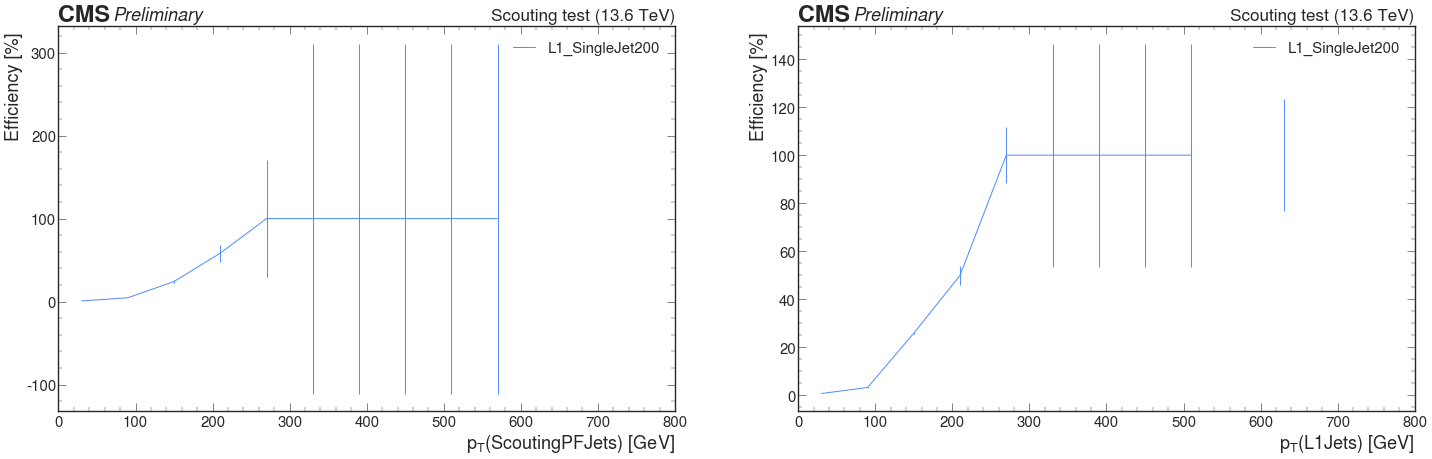

In [66]:
jet_eff = [v for k, v in efficiency_triggers.items() if k.startswith('Jet')]
jet_eff = jet_eff[0]

norm = False
objects = ['ScoutingPFJet', 'L1Jet']
ortho_trig = jet_eff[0]
int_trigs = jet_eff[1:]

get_ortho_name = lambda s, suf=None: f'ortho_{obj}_{suf}' if suf else f'ortho_{obj}'
get_int_name = lambda s, suf=None: f'int_{obj}_{suf}' if suf else f'int_{obj}'

fig, ax = plt.subplots(1, 2, figsize=(35, 10))
xrange = [(0,800), (0,800)]

for i, obj in enumerate(objects):
    for int_trig in int_trigs:
        ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
            
        draw_efficiency(ortho_hist, int_hist, ax[i], label=int_trig, rebin=15, norm=norm)

        hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        ax[i].set_xlim(*xrange[i])
        ax[i].set_xlabel(f'$p_{{T}}({obj+"s"})$ [GeV]', loc='right')
        ax[i].set_ylabel(f'Efficiency [%] {" [A.U.]" if norm else ""}', loc='top')
        ymin, ymax = ax[i].get_ylim()
        ax[i].set_ylim((ymin,ymax*1))
        ax[i].legend(loc='upper right')

**Muon efficiency using JetHT**

/tmp/ipykernel_204/2032970629.py:57: RuntimeWarning: invalid value encountered in divide
  eff = (trig_counts[0] / ortho_counts[0]) * 100
/tmp/ipykernel_204/2032970629.py:61: RuntimeWarning: invalid value encountered in divide
  f = trig_counts[0] / ortho_counts
/tmp/ipykernel_204/2032970629.py:64: RuntimeWarning: divide by zero encountered in divide
  error = f*np.sqrt((sig_trig/trig_counts[0])**2 + (sig_ortho/ortho_counts[0])**2)
/tmp/ipykernel_204/2032970629.py:64: RuntimeWarning: invalid value encountered in multiply
  error = f*np.sqrt((sig_trig/trig_counts[0])**2 + (sig_ortho/ortho_counts[0])**2)


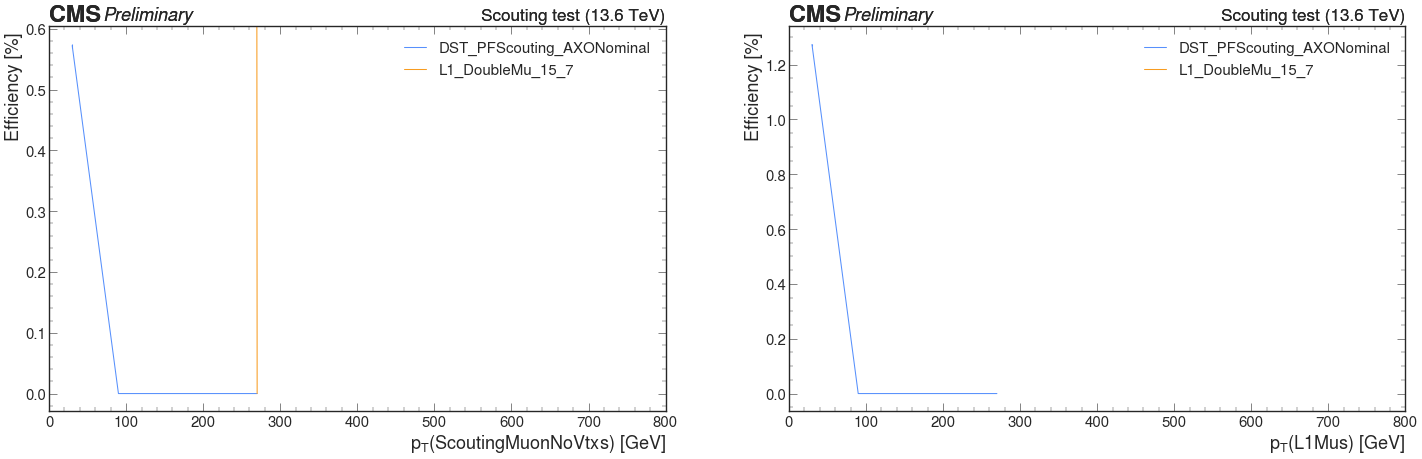

In [48]:
muon_eff = [v for k, v in efficiency_triggers.items() if k.startswith('Muon')]
muon_eff = muon_eff[0]

norm = False
objects = ['ScoutingMuonNoVtx', 'L1Mu']
ortho_trig = muon_eff[0]
int_trigs = muon_eff[1:]

get_ortho_name = lambda s, suf=None: f'ortho_{obj}_{suf}' if suf else f'ortho_{obj}'
get_int_name = lambda s, suf=None: f'int_{obj}_{suf}' if suf else f'int_{obj}'

fig, ax = plt.subplots(1, 2, figsize=(35, 10))
xrange = [(0,800), (0,800)]

for i, obj in enumerate(objects):
    for int_trig in int_trigs:
        ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
            
        draw_efficiency(ortho_hist, int_hist, ax[i], label=int_trig, rebin=15, norm=norm)

        hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        ax[i].set_xlim(*xrange[i])
        ax[i].set_xlabel(f'$p_{{T}}({obj+"s"})$ [GeV]', loc='right')
        ax[i].set_ylabel(f'Efficiency [%] {" [A.U.]" if norm else ""}', loc='top')
        ymin, ymax = ax[i].get_ylim()
        ax[i].set_ylim((ymin,ymax*1))
        ax[i].legend(loc='upper right')